# Cloud Detection in Landsat 8 Images

In this notebook we will use a UNET CNN architecture to detect cloud and cloud shadows in Landsat 8 Imagery

In [5]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import tensorflow as tf
import xarray as xr
from PIL import Image
from rasterio.windows import Window
from sklearn.model_selection import train_test_split
from tensorflow import keras

from cloud_detection.config import data_root, sample_root, target_root, IMG_SIZE, INPUT_SHAPE, BATCH_SIZE, EPOCHS, custom_cmap, custom_norm, \
    NUM_CLASSES, standard_image
from cloud_detection.data.generator import DataGenerator
from cloud_detection.data.scene import Scene
from cloud_detection.models.unet import UNet
from cloud_detection.utils import get_l8_color, get_mask_array
from cloud_detection.models.metrics import get_mean_iou, get_prediction


data_files = sorted(list(data_root.glob('*_data.tif')))
quality_files = sorted(list(data_root.glob('*_qmask.tif')))
mask_files = sorted(list(data_root.glob('*_mask.png')))

warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

%load_ext autoreload
%autoreload 2

Num GPUs Available:  1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ds = xr.open_dataset(standard_image)
ds

<xarray.Dataset>
Dimensions:      (band: 10, x: 1000, y: 1000)
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 2.4e+05 2.4e+05 2.401e+05 ... 2.7e+05 2.7e+05
  * y            (y) float64 -3.36e+06 -3.36e+06 ... -3.39e+06 -3.39e+06
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

# Examine some of the samples and their labels

data\LC80010812013365LGN00_18_data.tif
data\LC80020622013244LGN00_32_data.tif
data\LC80050152014172LGN00_12_data.tif


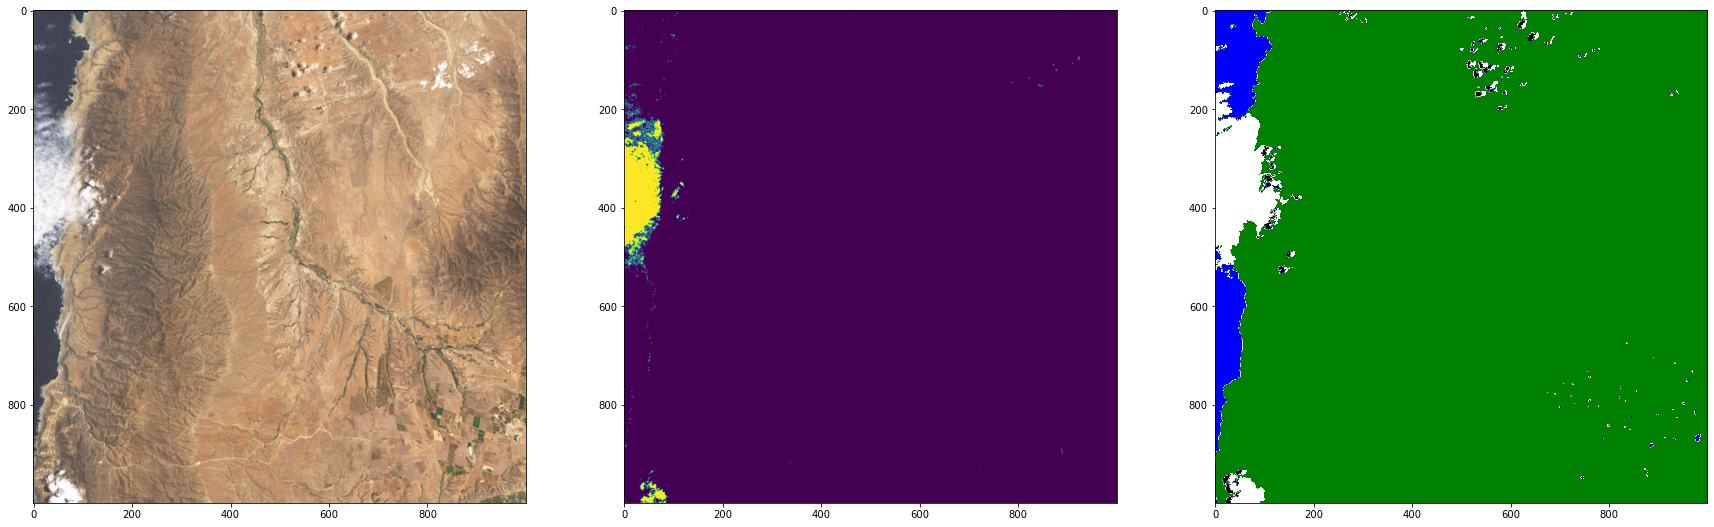

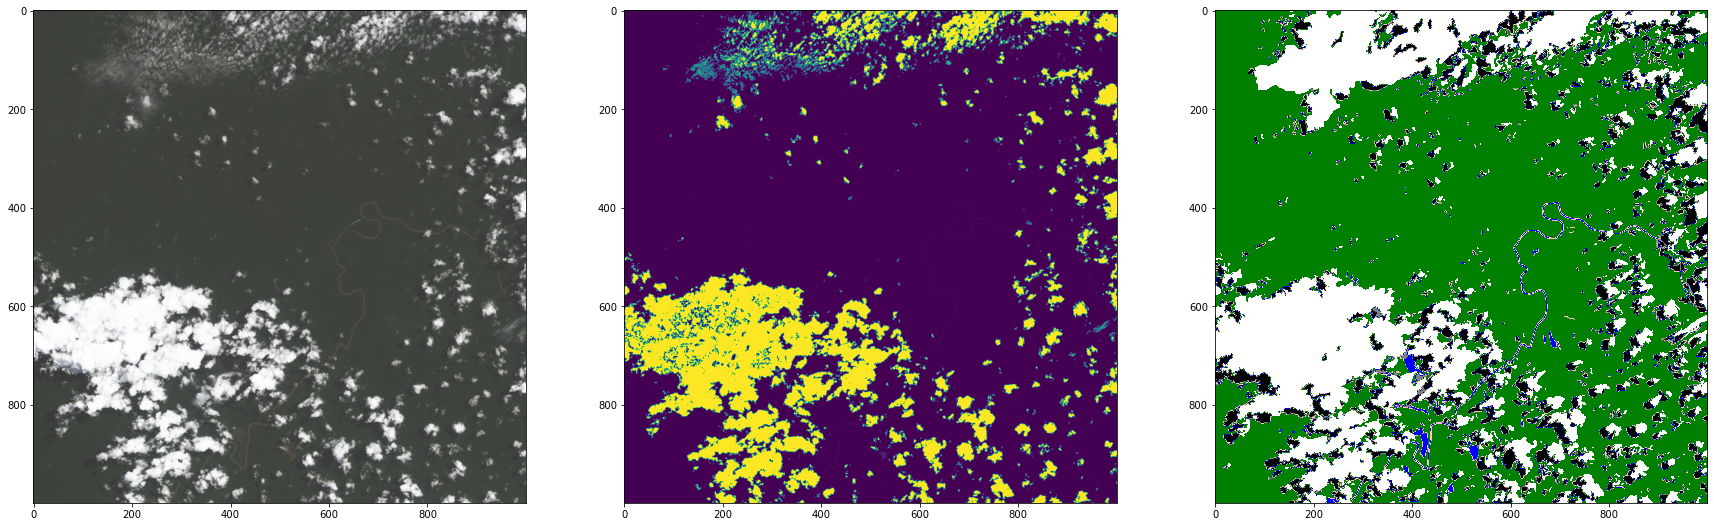

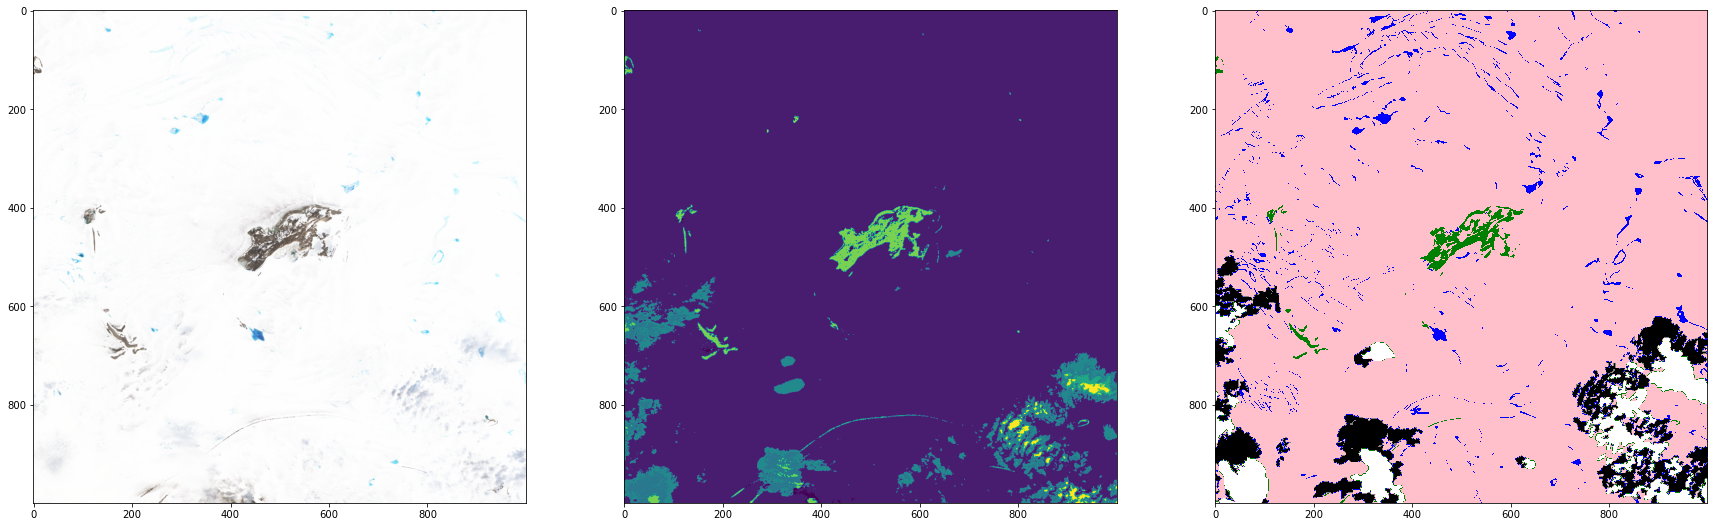

In [4]:
n_files = 3

for data_file, quality_file, mask_file in zip(data_files[:n_files], quality_files[:n_files], mask_files[:n_files]):
    print(data_file)
    color = get_l8_color(data_file)
    mask = get_mask_array(mask_file)
   
    quality = xr.open_dataset(quality_file)
    quality_plot = quality.sel({'band': 1}).band_data

    fig, ax = plt.subplots(1,3,figsize=(30, 10))
    ax[0].imshow(color.values)
    ax[1].imshow(quality_plot.values)
    ax[2].imshow(mask, cmap=custom_cmap, norm=custom_norm)

# Prepare samples
Here we cut the samples into chips to more easily fit into memory. We also correct to top of atmosphere reflectance using the scene metadata file.

In the future, I should retain the rest of the image (bottom right) via padding.

In [5]:
kernel_x, kernel_y = IMG_SIZE

for data_file, mask_file in zip(data_files, mask_files):
    scene = Scene(data_file)
    mask = rasterio.open(mask_file)
    x_dim, y_dim = scene.geodata.band_data.sel({'band': 2}).shape
    
    chip = 0
    for x1, x2 in zip(np.arange(0, x_dim, kernel_x), np.arange(kernel_x, x_dim, kernel_x)):
        for y1, y2 in zip(np.arange(0, y_dim, kernel_y), np.arange(kernel_y, y_dim, kernel_y)):
            data_chip = scene.geodata.isel(x=slice(x1, x2), y=slice(y1,y2))
            data_chip.band_data.rio.to_raster(os.path.join(str(sample_root.absolute()), data_file.stem + f'_{chip}.tif'))
                     
            window = Window.from_slices((y1, y2), (x1, x2))
            mask_data = mask.read(1, window=window)
           
            im = Image.fromarray(mask_data)
            im.save(os.path.join(str(target_root.absolute()), data_file.stem + f'_{chip}.tif'))

            chip += 1

# Verify chips

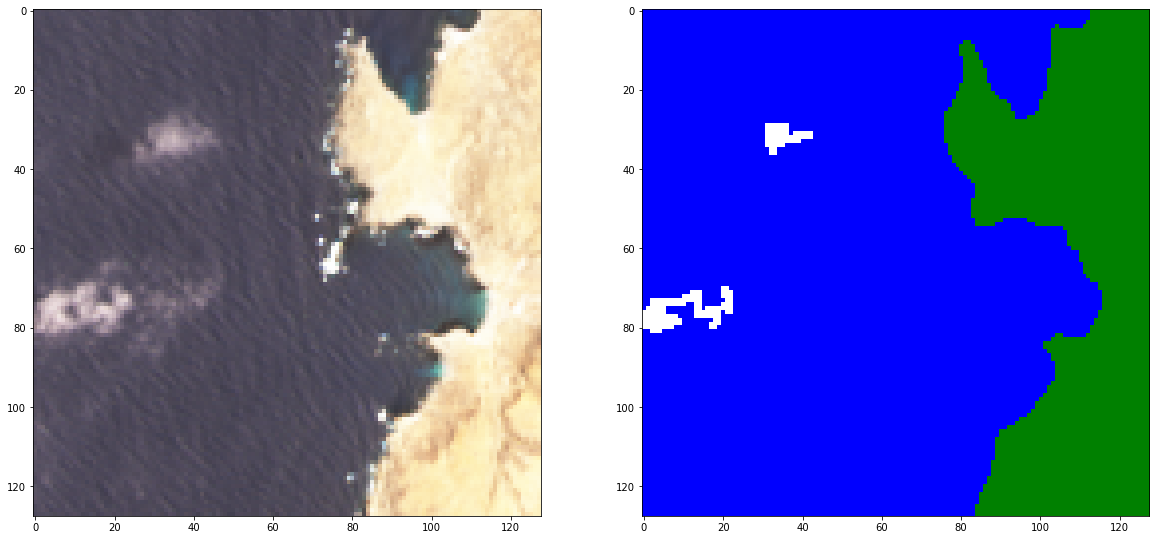

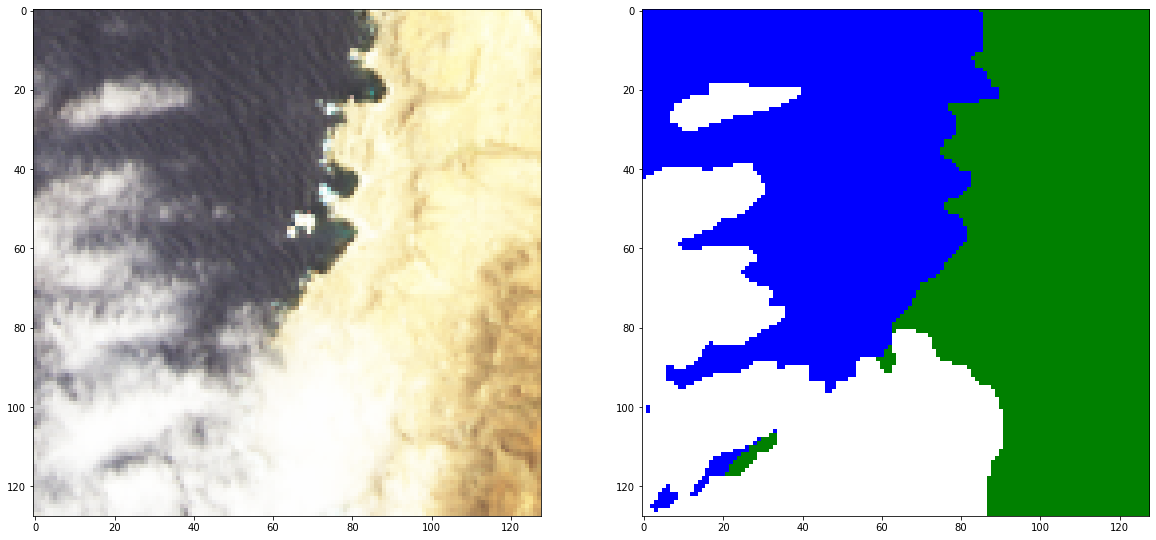

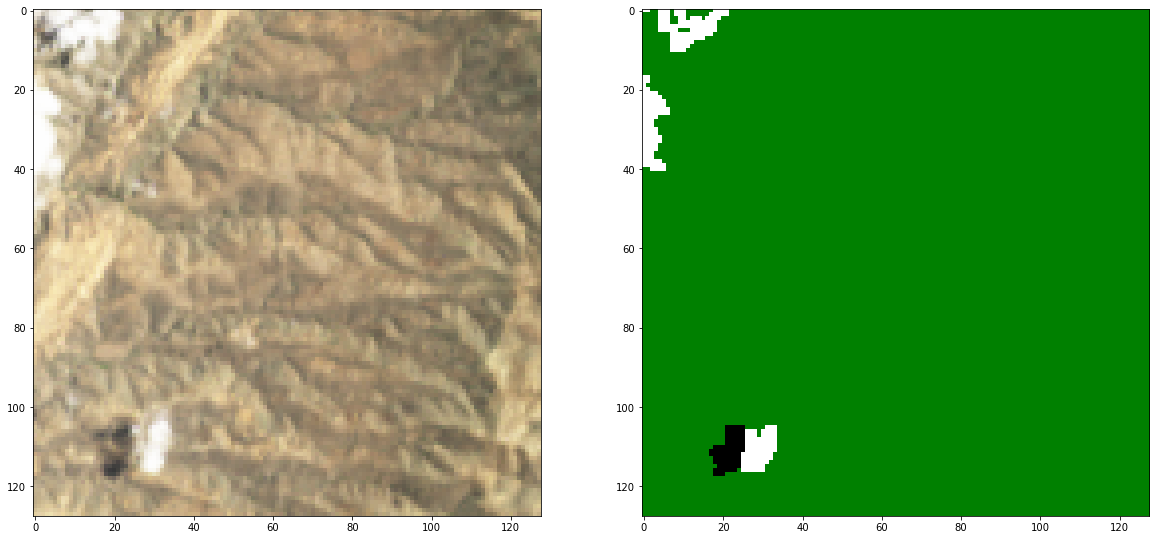

In [6]:
data_files = sorted(list(sample_root.glob('*.tif')))
mask_files = sorted(list(target_root.glob('*.tif')))

n_files = 3

for data_file, mask_file in zip(data_files[:n_files], mask_files[:n_files]):
    color = get_l8_color(data_file)
    mask = get_mask_array(mask_file)

    fig, ax = plt.subplots(1,2,figsize=(20, 10))
    ax[0].imshow(color.values[:,:,0:3])
    ax[1].imshow(mask, cmap=custom_cmap, norm=custom_norm)

# Create a data generator

In [10]:
seed = 1334
sample_files = sorted(list(sample_root.glob('*.tif')))
target_files = sorted(list(target_root.glob('*.tif')))

sample_files = [str(file.absolute()) for file in sample_files]
target_files = [str(file.absolute()) for file in target_files]

X_train, X_test, y_train, y_test = train_test_split(sample_files, target_files, test_size=0.2, random_state=seed)

train_generator = DataGenerator(BATCH_SIZE, IMG_SIZE, X_train, y_train)
test_generator = DataGenerator(BATCH_SIZE, IMG_SIZE, X_test, y_test)

# Create model and run

In [30]:
model = UNet(INPUT_SHAPE)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES),
                       tf.keras.metrics.OneHotIoU(7, [0, 1, 2, 3, 4, 5, 6]),
                       tf.keras.metrics.CategoricalAccuracy()])

callbacks = [keras.callbacks.ModelCheckpoint("checkpoint.h5", save_best_only=True),

             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss',
                 min_delta=0.01,
                 patience=10,
                 verbose=0,
                 mode='auto',
                 baseline=None,
                 restore_best_weights=True
             )

             ]

history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=callbacks)


Epoch 1/50
196/196 [==============================] - 71s 351ms/step - loss: 0.6416 - one_hot_mean_io_u_3: 0.4090 - one_hot_io_u_3: 0.4090 - categorical_accuracy: 0.8142 - val_loss: 1.1497 - val_one_hot_mean_io_u_3: 0.1015 - val_one_hot_io_u_3: 0.1015 - val_categorical_accuracy: 0.4107
Epoch 2/50
196/196 [==============================] - 69s 349ms/step - loss: 0.4630 - one_hot_mean_io_u_3: 0.4698 - one_hot_io_u_3: 0.4698 - categorical_accuracy: 0.8517 - val_loss: 0.5799 - val_one_hot_mean_io_u_3: 0.4516 - val_one_hot_io_u_3: 0.4516 - val_categorical_accuracy: 0.8357
Epoch 3/50
196/196 [==============================] - 68s 343ms/step - loss: 0.4212 - one_hot_mean_io_u_3: 0.4882 - one_hot_io_u_3: 0.4882 - categorical_accuracy: 0.8615 - val_loss: 0.4271 - val_one_hot_mean_io_u_3: 0.5395 - val_one_hot_io_u_3: 0.5395 - val_categorical_accuracy: 0.8678
Epoch 4/50
196/196 [==============================] - 68s 344ms/step - loss: 0.4003 - one_hot_mean_io_u_3: 0.5120 - one_hot_io_u_3: 0.5120 

Text(0, 0.5, 'accuracy')

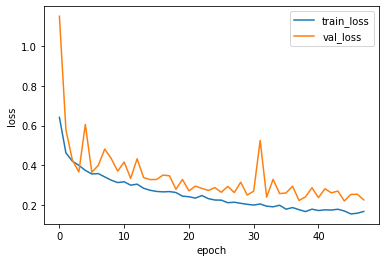

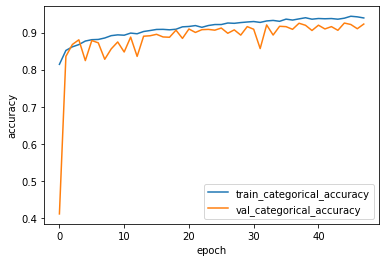

In [31]:
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

plt.figure()
plt.plot(history.history['categorical_accuracy'], label='train_categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [35]:
model.save('UNET_MODEL')

INFO:tensorflow:Assets written to: UNET_MODEL\assets


In [8]:
model = tf.keras.models.load_model('UNET_MODEL')

# Evaluate the model
For semantic segmentation we often use Intersection-over-Union as a metric

In [11]:
val_preds = model.predict(test_generator)

In [74]:
val_preds.shape

(784, 128, 128, 7)

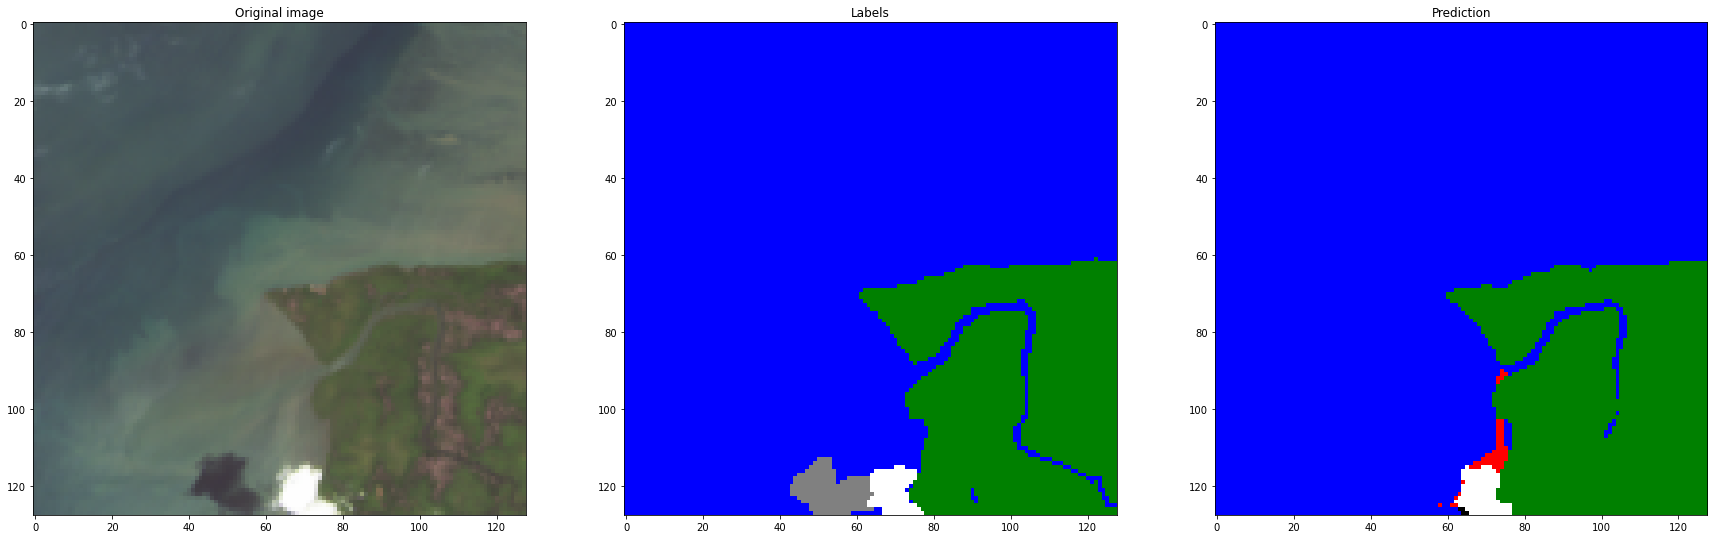

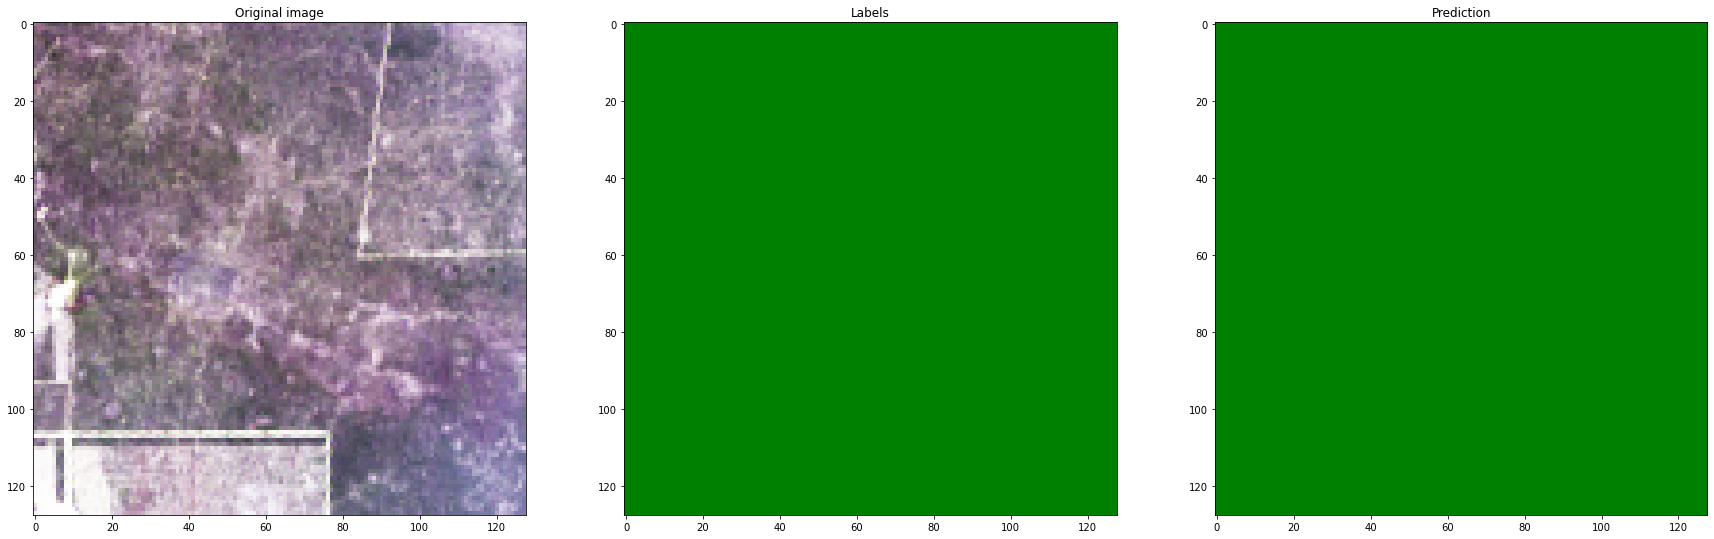

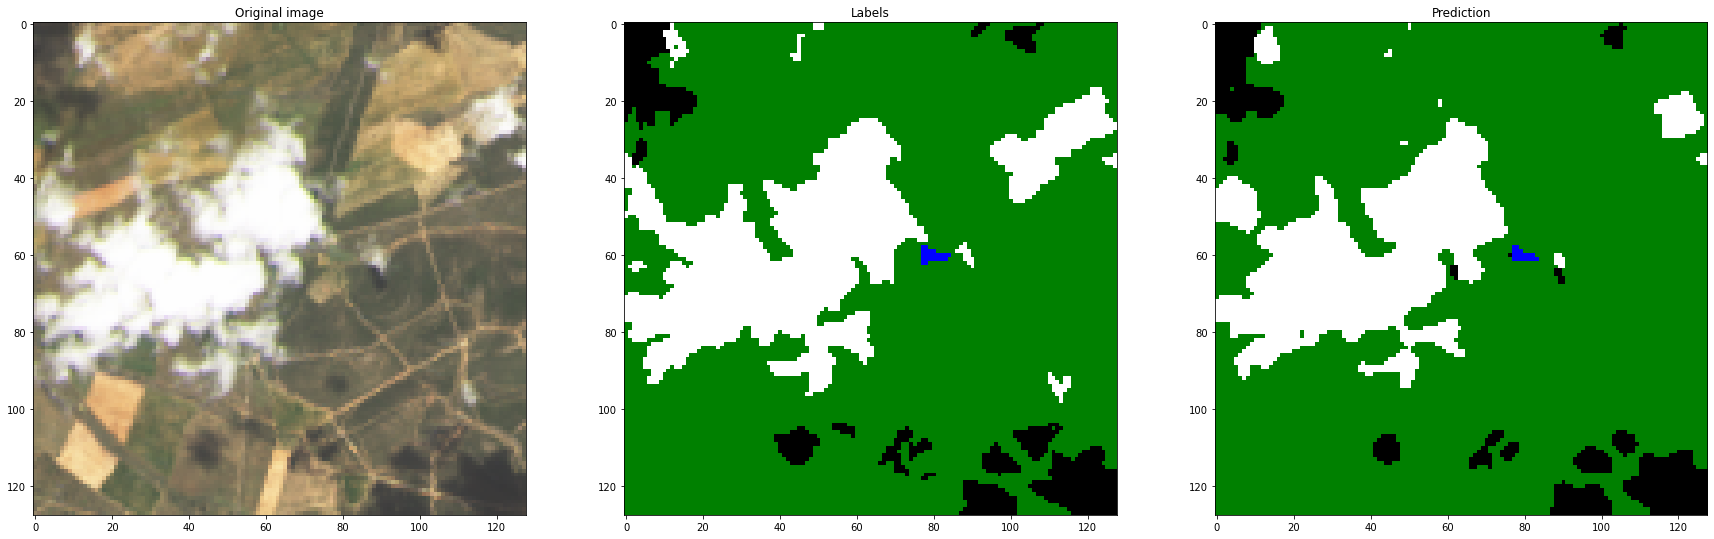

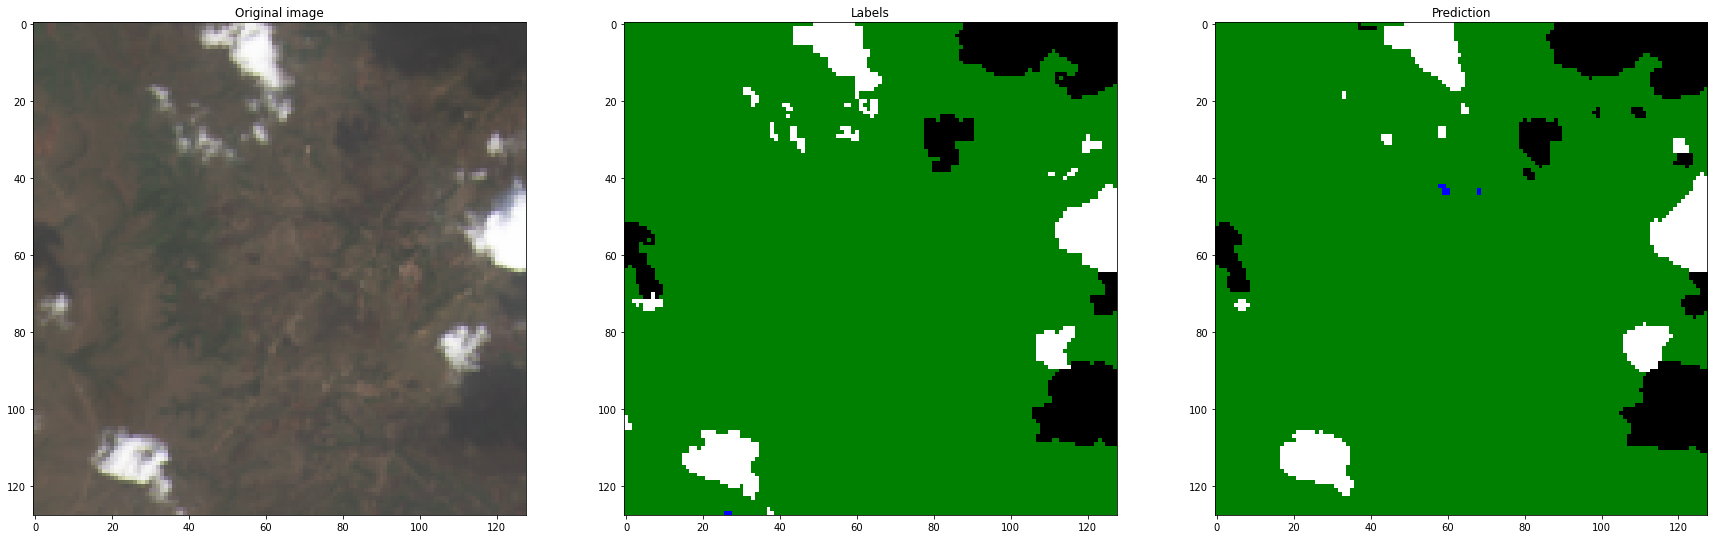

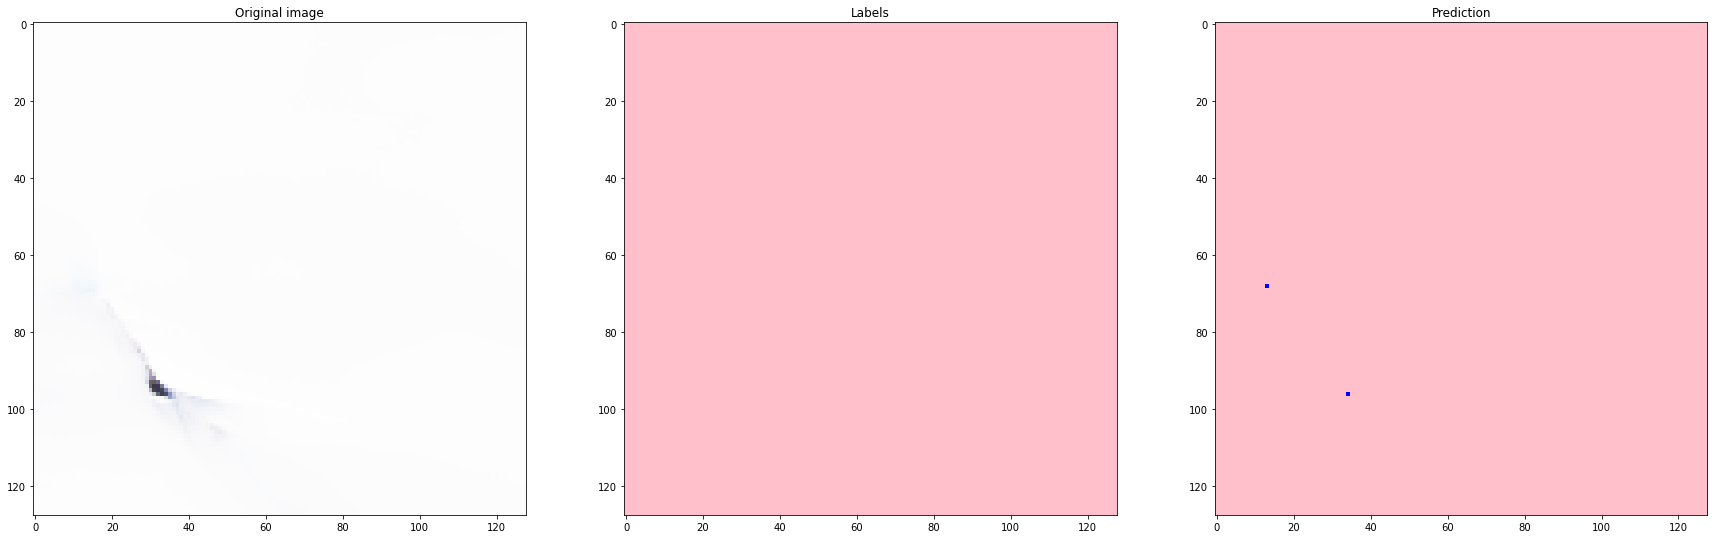

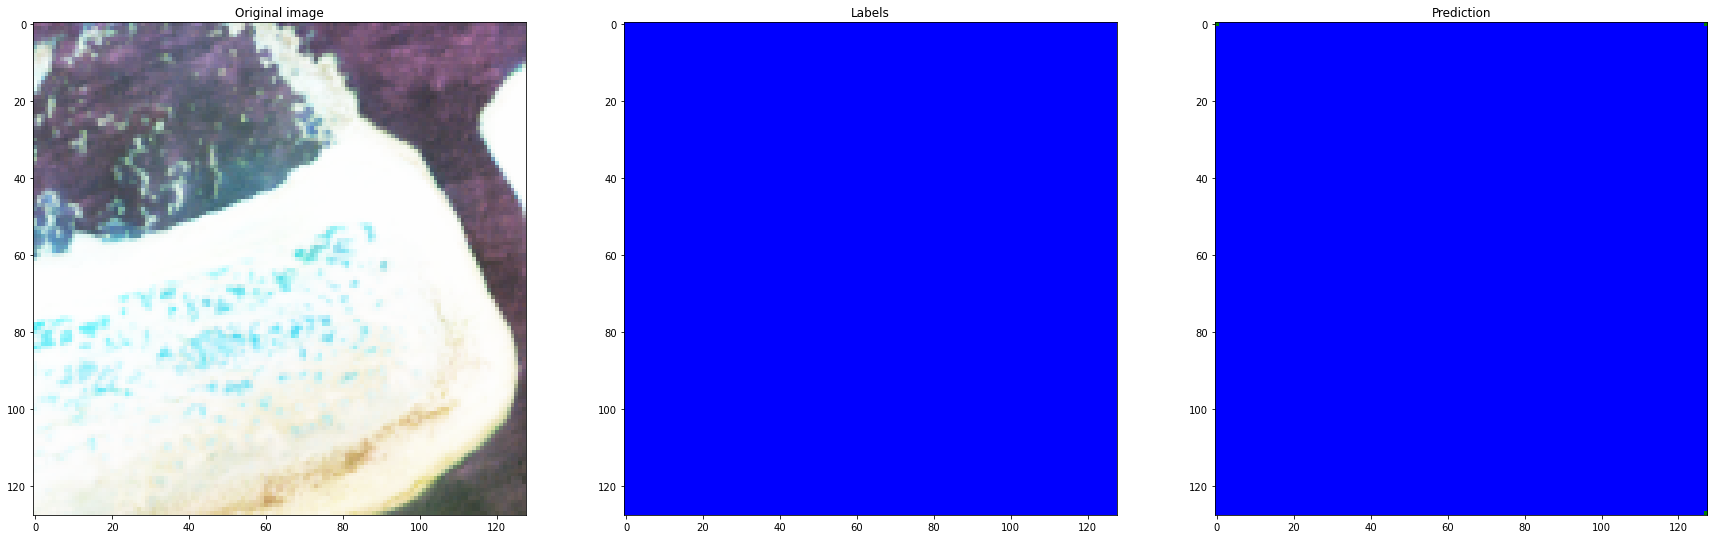

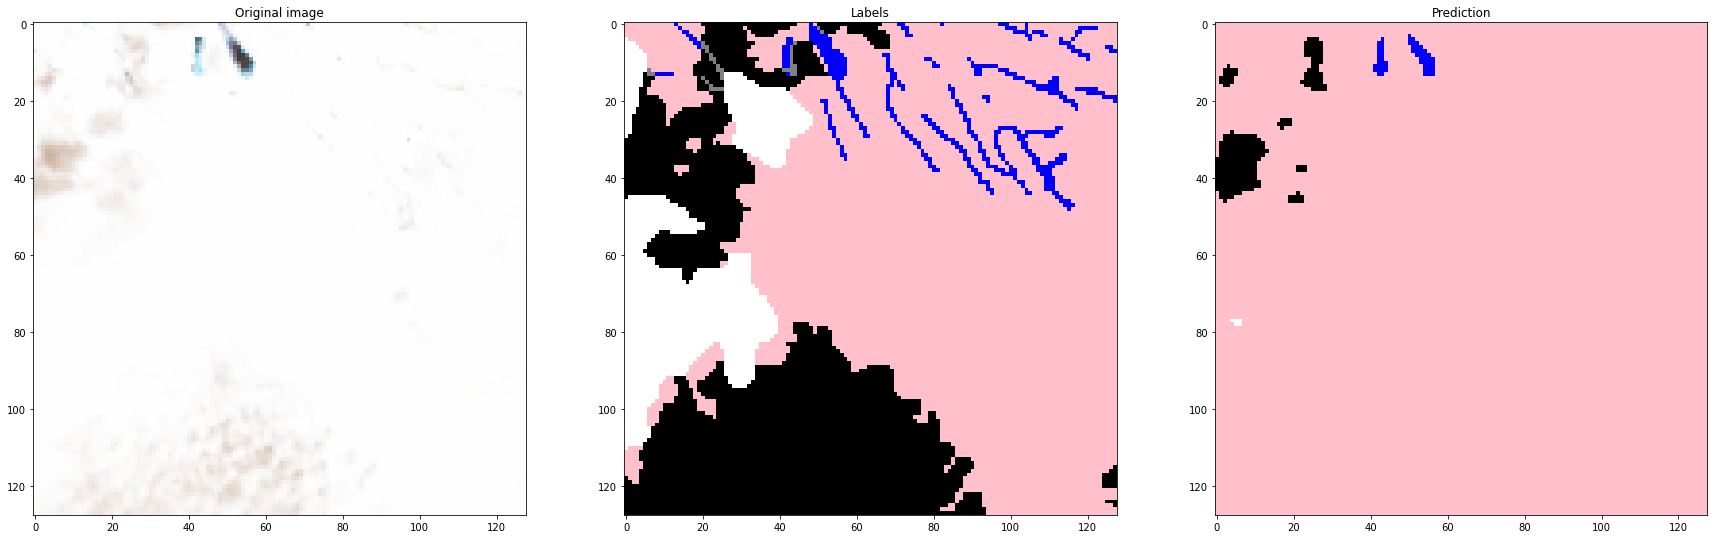

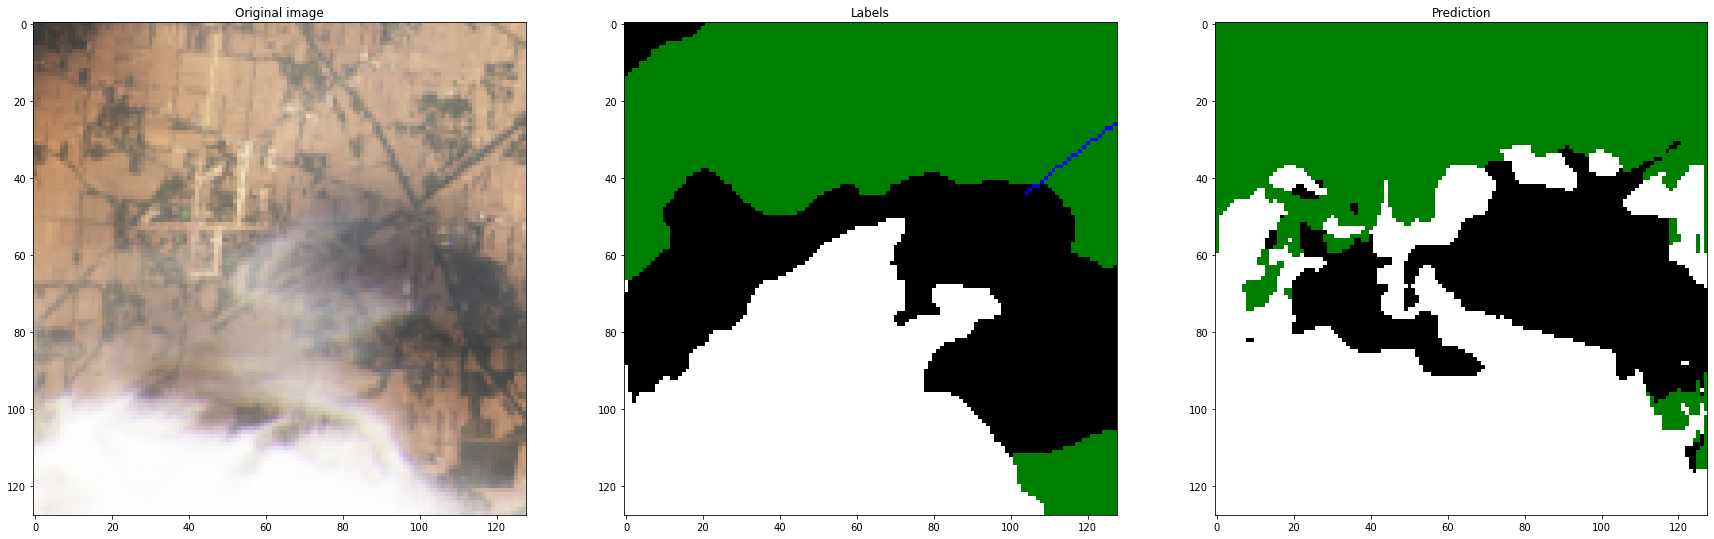

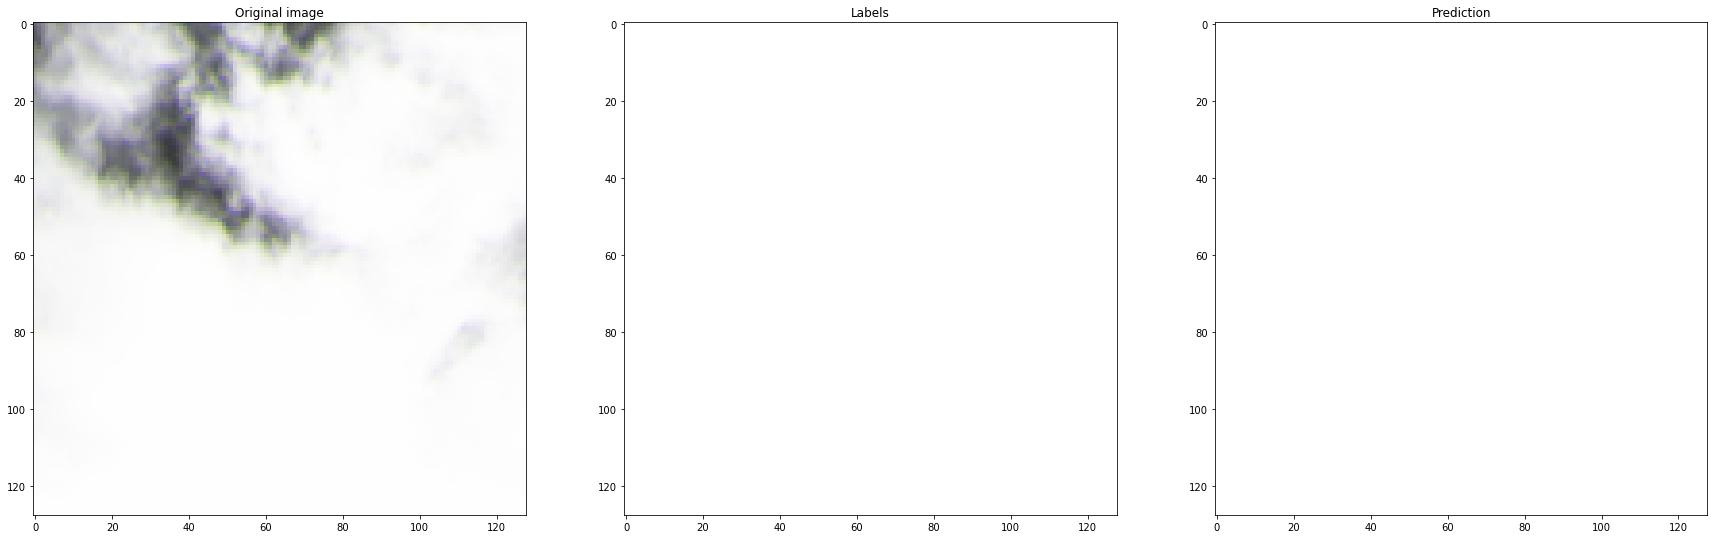

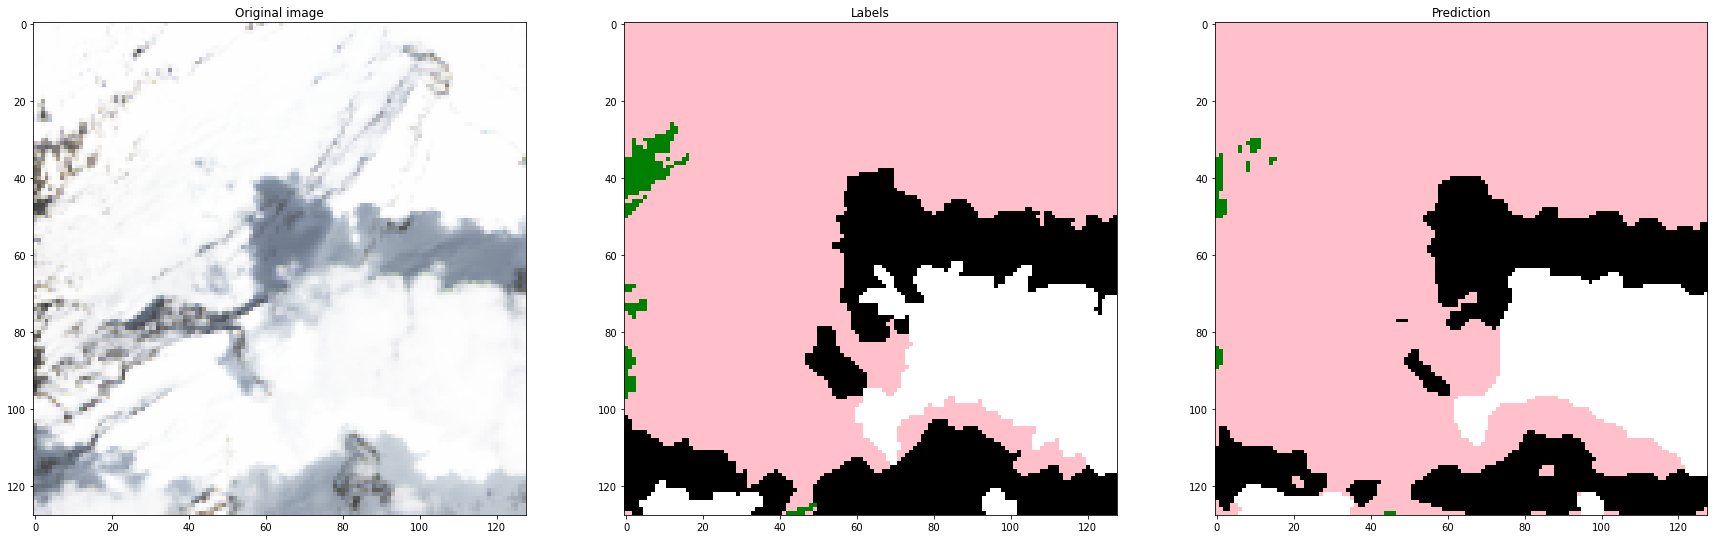

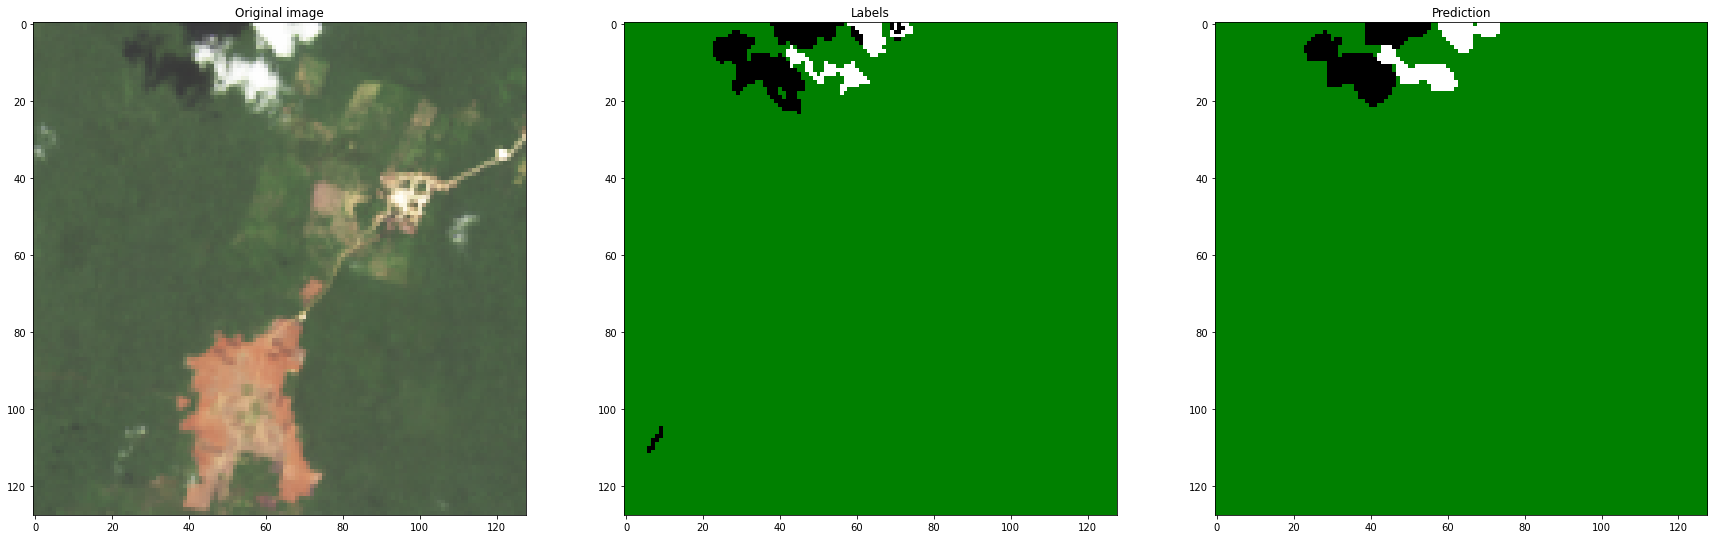

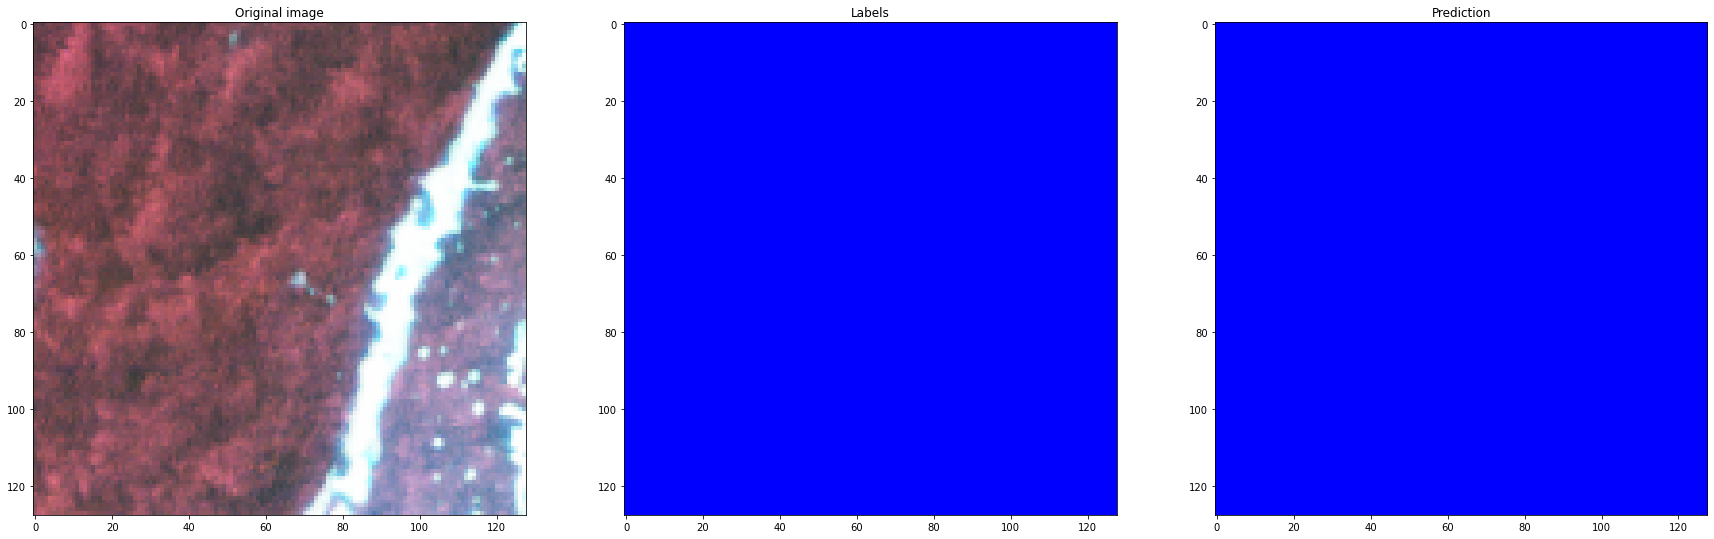

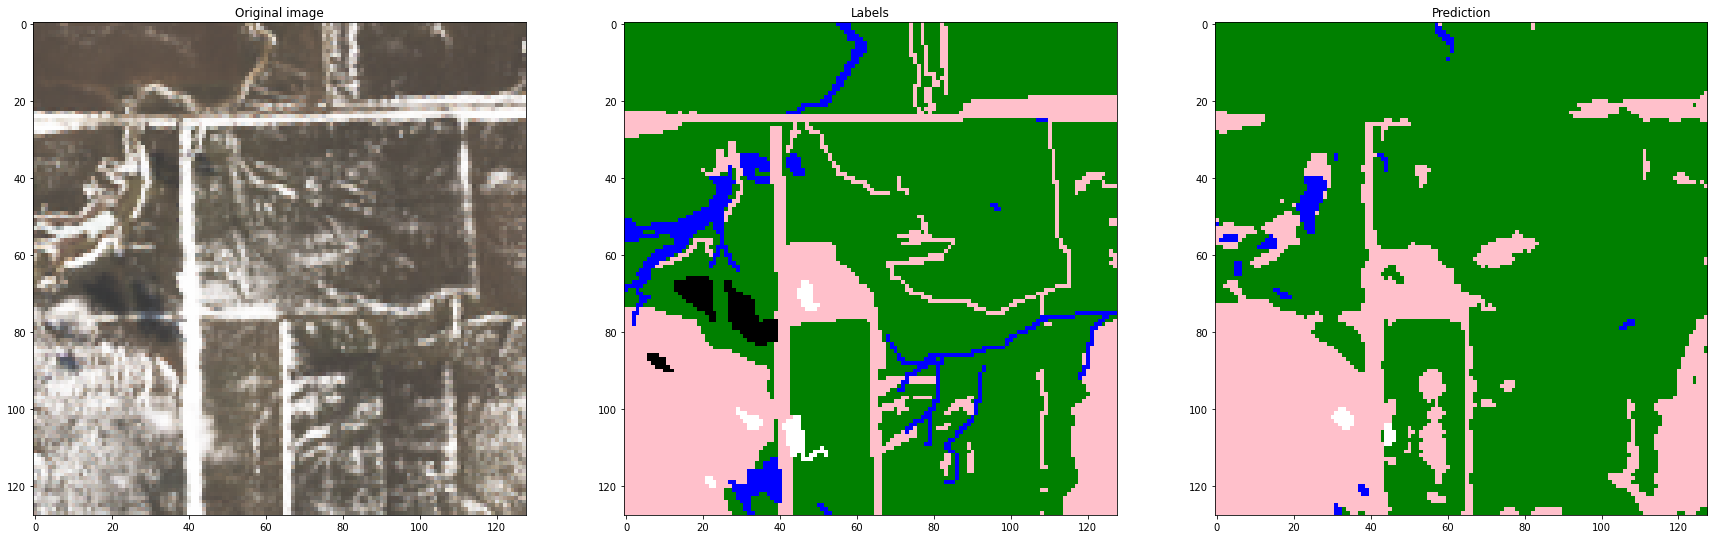

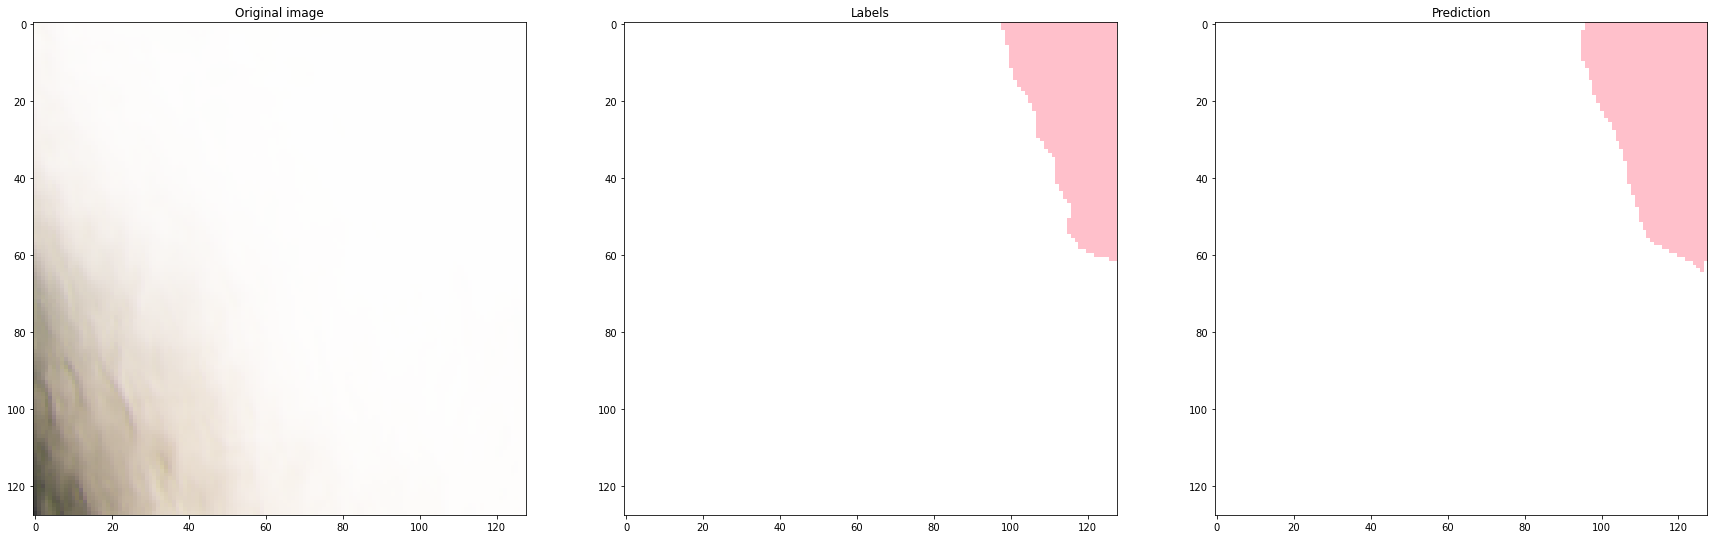

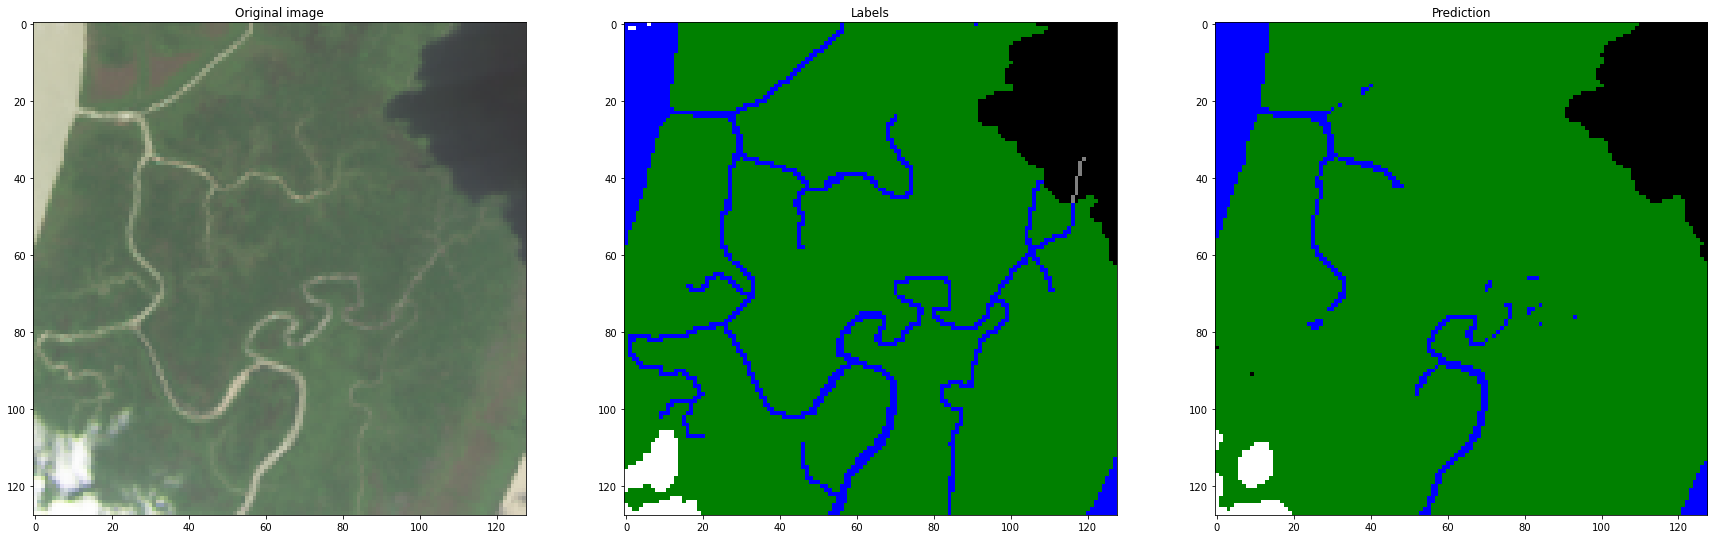

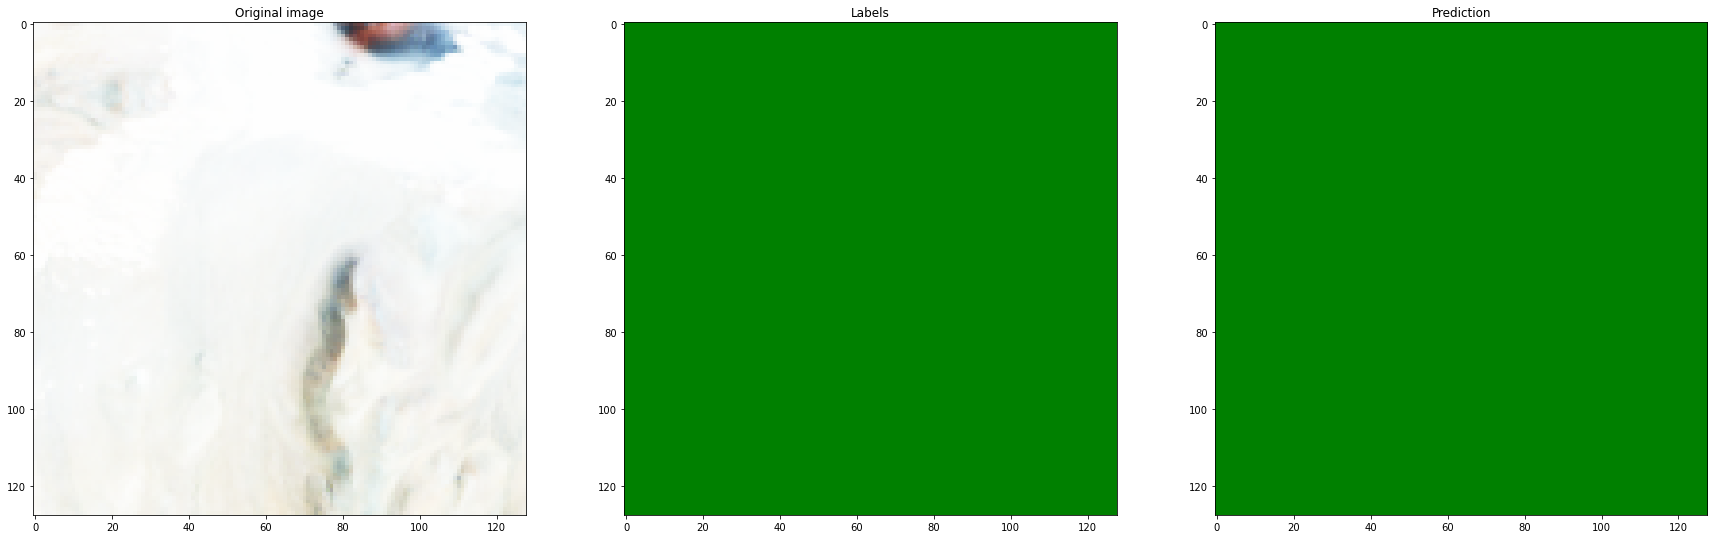

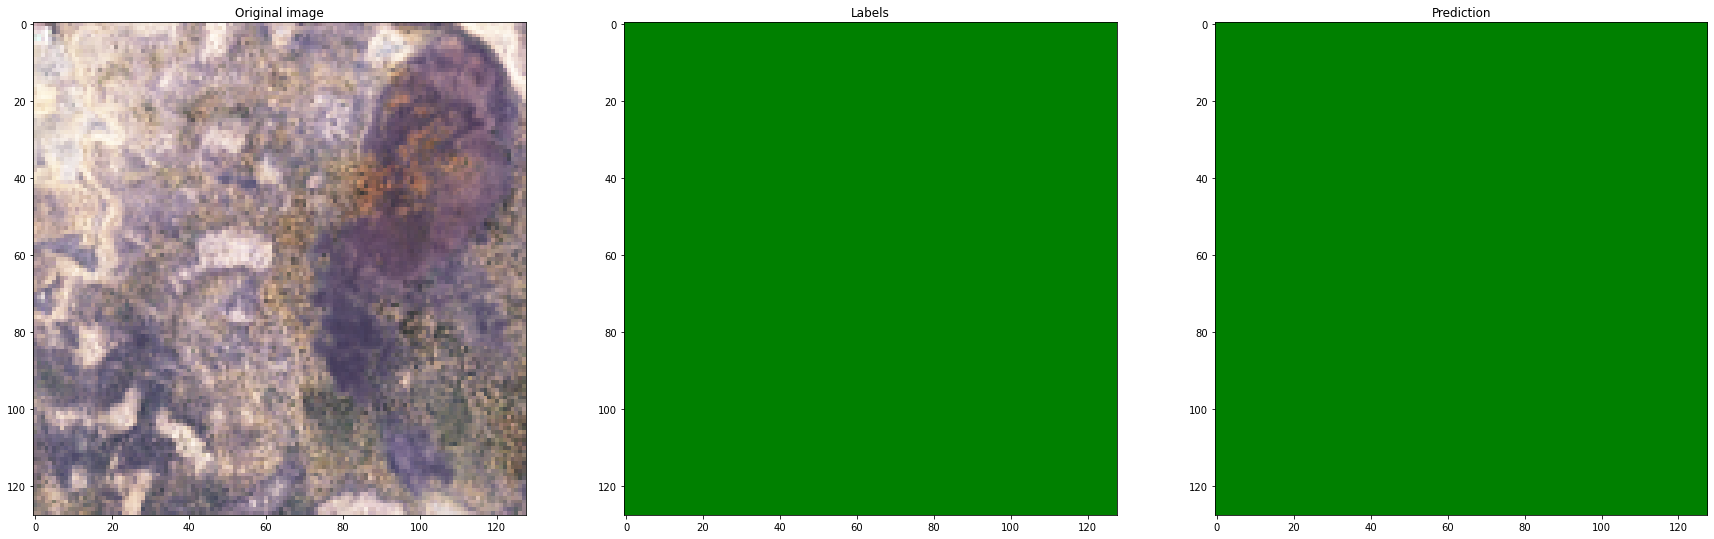

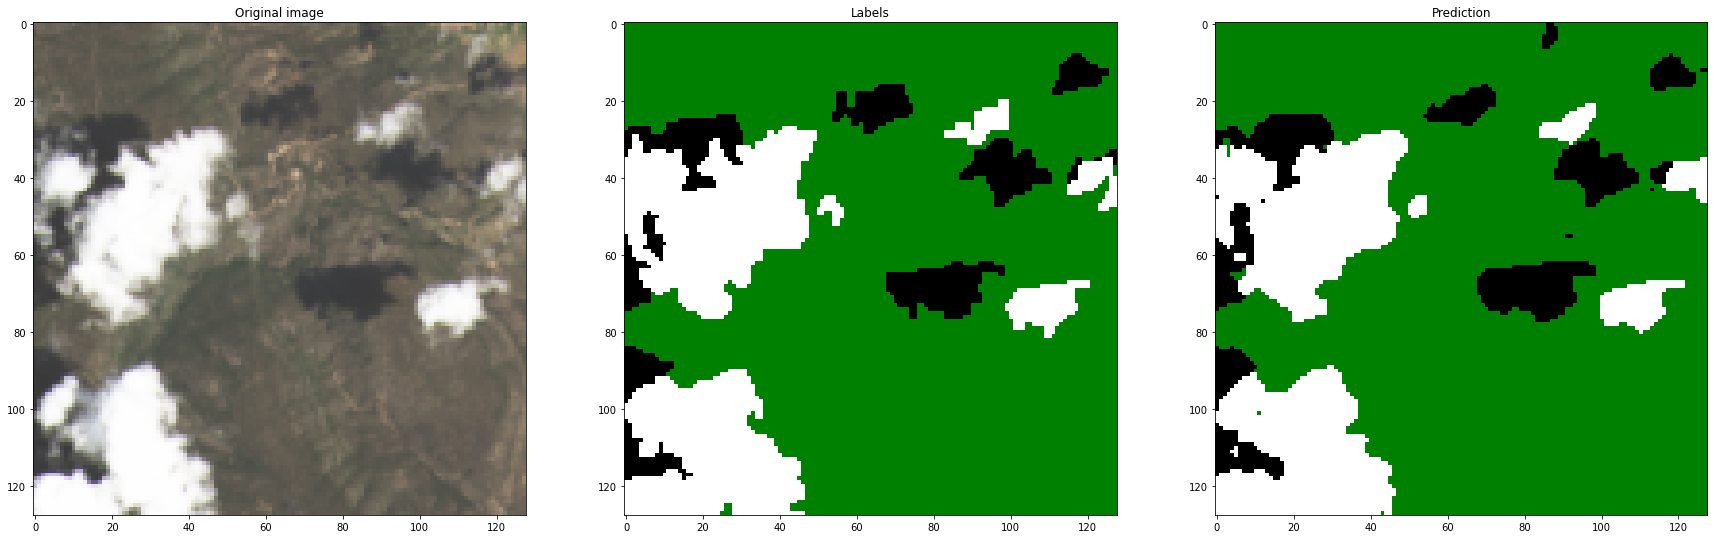

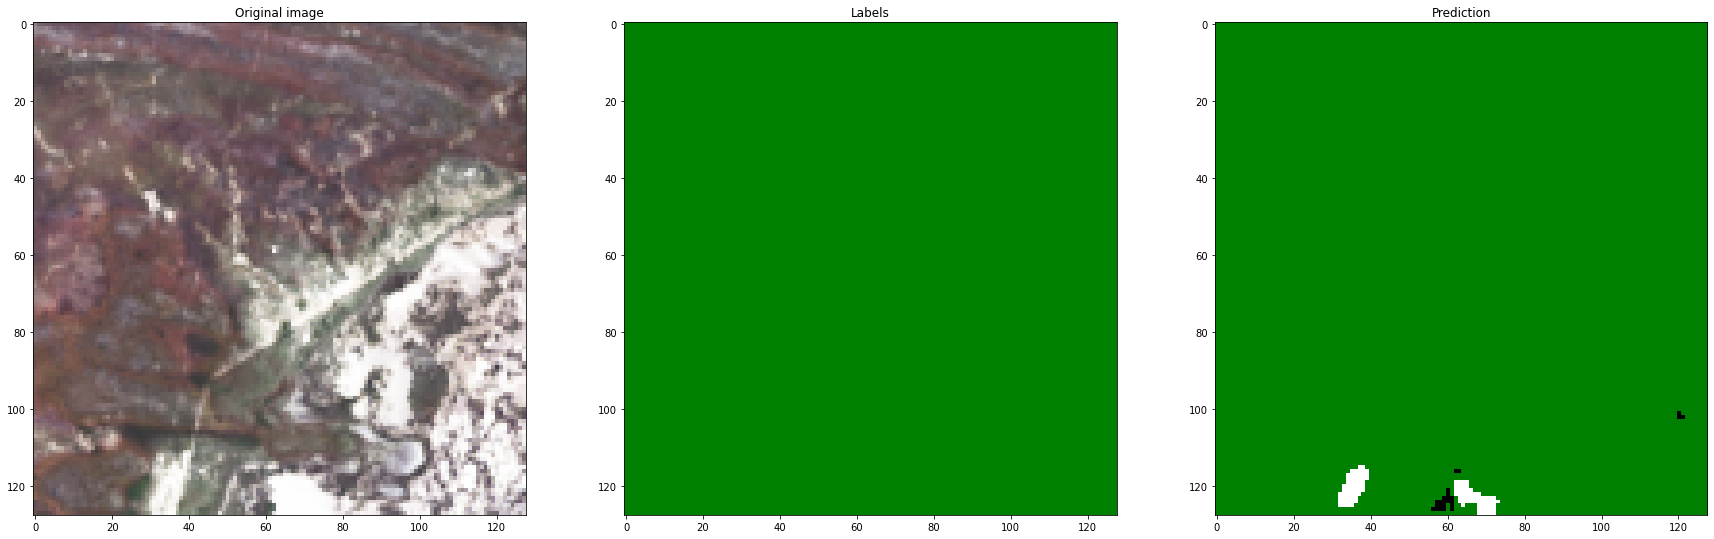

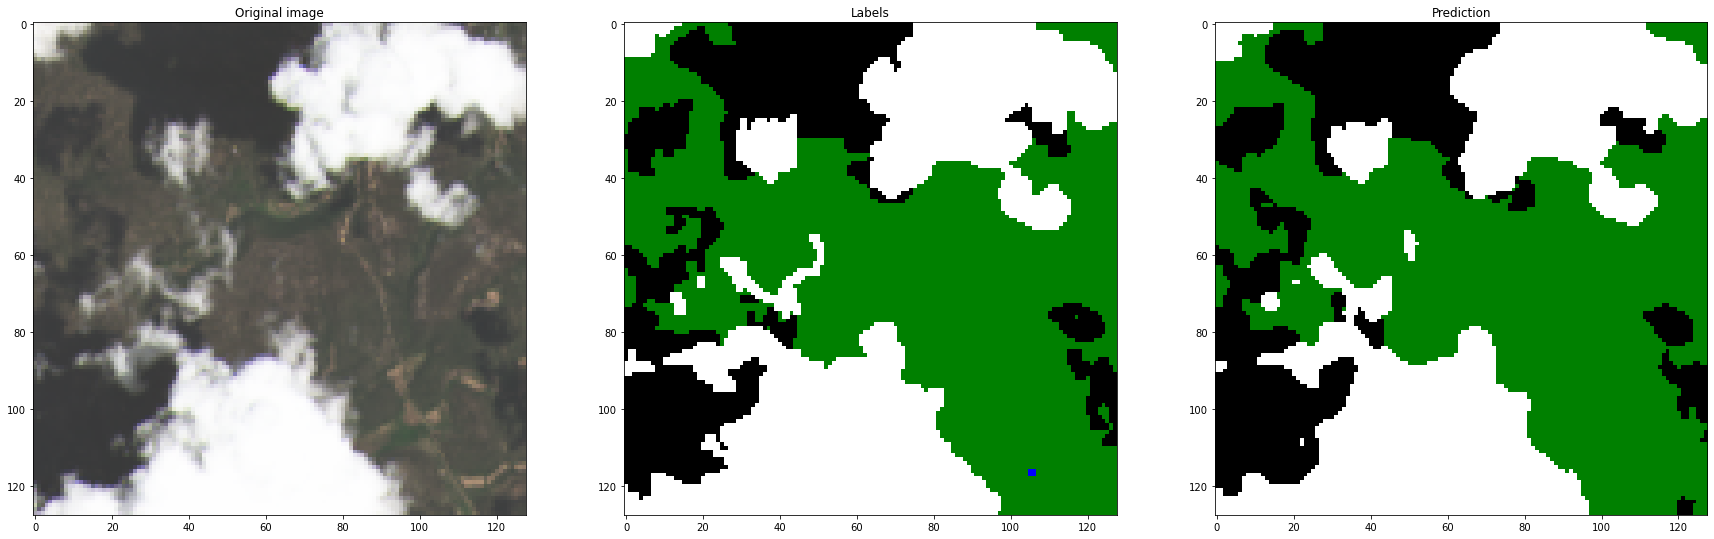

In [12]:
for idx in np.random.choice(range(len(y_test)-1), 20):

    color = get_l8_color(X_test[idx])
    mask = get_mask_array(y_test[idx])
    result = val_preds[idx]

    fig, ax = plt.subplots(1,3,figsize=(30,10))
    ax[0].imshow(color[:,:,0:3])
    ax[0].set_title('Original image')
    ax[1].imshow(mask,cmap=custom_cmap, norm=custom_norm)
    ax[1].set_title('Labels')
    ax[2].imshow(get_prediction(result), cmap=custom_cmap, norm=custom_norm)
    ax[2].set_title('Prediction')

C:\Users\rudys\AppData\Local\Temp\ipykernel_1076\499596584.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.boxplot(np.array([iou[key] for key in iou.keys()]))


Text(0, 0.5, 'Distribution of per-class IOU across chips')

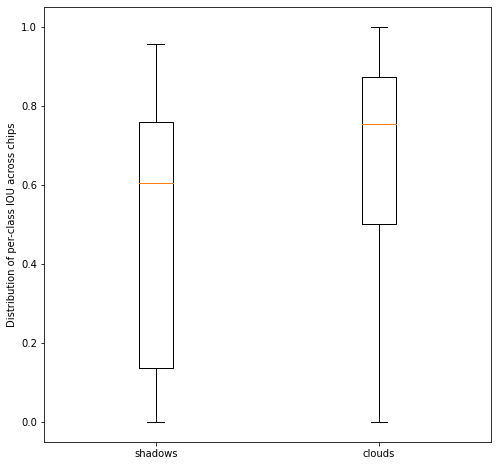

In [68]:
iou = get_mean_iou(y_test, val_preds, classes=[0,5], labels=['shadows', 'clouds'])

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.boxplot(np.array([iou[key] for key in iou.keys()]))
ax.set_xticklabels([key for key in iou.keys()])
ax.set_ylabel('Distribution of per-class IOU across chips')

In [73]:
[print(f'Median IOU for {key} class = {np.median(iou[key])}') for key in iou.keys()]

Median IOU for shadows class = 0.6049249834783587
Median IOU for clouds class = 0.7547683923705722


[None, None]